# Análise de Erros, Trade-offs e Estratégias de Melhoria - AMST - Predição de Color EBC

Após a etapa de modelagem avançada, foi selecionado um modelo com bom desempenho global e características adequadas para uso operacional. No entanto, métricas agregadas, como RMSE ou MAE, nem sempre capturam completamente o comportamento do modelo ao longo de toda a distribuição do target, especialmente em regiões menos frequentes ou de maior impacto operacional.

O objetivo deste notebook é aprofundar a análise dos erros do modelo selecionado, investigando seu desempenho por diferentes faixas de cor (EBC) e avaliando de forma crítica suas limitações. Essa análise permite compreender não apenas *quanto* o modelo erra, mas *onde* e *em que condições* esses erros ocorrem, fornecendo insumos importantes para decisões técnicas e de negócio.

Nesta etapa, são exploradas abordagens complementares para mitigar limitações observadas nos extremos do target, incluindo técnicas de ponderação de amostras e métodos de reamostragem voltados para dados desbalanceados em regressão. O impacto dessas estratégias é avaliado tanto em termos de melhoria local quanto de possíveis perdas de desempenho global, evidenciando os trade-offs envolvidos.

Ao final deste notebook, o foco não é apenas propor um modelo alternativo, mas consolidar uma decisão consciente sobre o modelo a ser utilizado em produção, considerando precisão, estabilidade e robustez operacional. Essa análise também orienta recomendações práticas para uso complementar do modelo e para futuras evoluções da solução.



## 1. Imports e Carregamento dos Dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path("/content/drive/MyDrive/heineken_case").resolve()

if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError(f"Não achei a pasta src em: {PROJECT_ROOT}")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_PATH = PROJECT_ROOT / "data" / "Heineken - Data Science Use Case 3.csv"
MODEL_PATH = PROJECT_ROOT / "models"

In [4]:
from typing import Dict, List

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline

from src.config import RANDOM_STATE, TEST_SIZE, TARGET_COL, Q_LOW, Q_HIGH, EXTREME_WEIGHT

from src.data.load_data import load_amst_clean
from src.features.preprocessing import add_domain_features, build_preprocess_pipeline, temporal_train_test_split

from src.models.io import load_model
from src.models.evaluation import eval_regression, evaluate_by_bins
from src.models.pipelines import build_xgb_pipeline, build_lgbm_pipeline

## 2. Carregar e preparar os dados (limpeza + features)

In [5]:
# Carregando os dados brutos
df = pd.read_csv(DATA_PATH)
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M", errors="coerce")

# Foco no produto AMST (escopo do case)
df_amst = df[df["Product"] == "AMST"].copy()
print("Dimensão AMST (bruto):", df_amst.shape)

# Regras de limpeza:
# - remover linhas sem target
# - remover Color < 0 (fisicamente impossível)
df_amst = df_amst[df_amst["Color"].notna()]
df_amst = df_amst[df_amst["Color"] >= 0]

# Ordenar temporalmente (importante para split de série temporal)
df_amst = df_amst.sort_values("Date/Time")

print("Dimensão AMST após limpeza:", df_amst.shape)

Dimensão AMST (bruto): (460, 22)
Dimensão AMST após limpeza: (427, 22)


In [6]:
# Feature engineering
df_amst["total_malt"] = (
    df_amst["Roast amount (kg)"]
    + df_amst["1st malt amount (kg)"]
    + df_amst["2nd malt amount (kg)"]
)

df_amst["roast_pct"] = np.where(
    df_amst["total_malt"] > 0,
    df_amst["Roast amount (kg)"] / df_amst["total_malt"],
    0.0
)

df_amst["mt_energy"] = df_amst["MT - Temperature"] * df_amst["MT - Time"]
df_amst["wk_energy"] = df_amst["WK - Temperature"] * df_amst["WK - Time"]

# Definir colunas a descartar como features
drop_cols = ["Unnamed: 0", "Product", "Job ID", "Date/Time"]

feature_cols = [
    c for c in df_amst.columns
    if c not in drop_cols + ["Color"]
]

print("Total de features:", len(feature_cols))
feature_cols

Total de features: 21


['Roast amount (kg)',
 '1st malt amount (kg)',
 '2nd malt amount (kg)',
 'MT - Temperature',
 'MT - Time',
 'WK - Temperature',
 'WK - Steam',
 'WK - Time',
 'Total cold wort',
 'pH',
 'Extract',
 'WOC - Time',
 'WHP Transfer - Time',
 'WHP Rest - Time',
 'Roast color',
 '1st malt color',
 '2nd malt color',
 'total_malt',
 'roast_pct',
 'mt_energy',
 'wk_energy']

## 3. Split temporal treino / teste

In [7]:
n_rows = df_amst.shape[0]
split_idx = int(n_rows * (1 - TEST_SIZE))

train = df_amst.iloc[:split_idx]
test  = df_amst.iloc[split_idx:]

X_train = train[feature_cols]
y_train = train["Color"]

X_test  = test[feature_cols]
y_test  = test["Color"]

print("Total linhas:", n_rows)
print("Treino:", X_train.shape[0], "| Teste:", X_test.shape[0])
print("Período treino: ", train["Date/Time"].min(), "→", train["Date/Time"].max())
print("Período teste : ", test["Date/Time"].min(),  "→", test["Date/Time"].max())

Total linhas: 427
Treino: 341 | Teste: 86
Período treino:  2020-10-22 02:50:00 → 2020-11-27 23:01:00
Período teste :  2020-11-27 23:16:00 → 2020-11-30 03:16:00


## 4. Caregar Melhor Modelo

In [8]:
best_model = load_model(MODEL_PATH/"best_model.joblib")

## 5. Treinamento com pesos (`sample_weight`)


Penalizando mais erros nas regiões raras do target.

In [9]:
# Definir extremos com base em quantis no TREINO
q_low  = y_train.quantile(0.10)
q_high = y_train.quantile(0.90)

print("Quantil 10% (baixo):", q_low)
print("Quantil 90% (alto):", q_high)

# Criar pesos: extremos recebem peso maior
# Ajuste o fator conforme necessário (2, 3, 4...)
EXTREME_WEIGHT = 3.0

sample_weight = np.ones(len(y_train), dtype=float)
sample_weight[(y_train <= q_low) | (y_train >= q_high)] = EXTREME_WEIGHT

print("Proporção de extremos no treino:",
      ((y_train <= q_low) | (y_train >= q_high)).mean())
print("Peso médio:", sample_weight.mean())

Quantil 10% (baixo): 10.51261547
Quantil 90% (alto): 31.667
Proporção de extremos no treino: 0.21700879765395895
Peso médio: 1.434017595307918


## 6. Pipeline de pré-processamento

In [10]:
preprocess = build_preprocess_pipeline(feature_cols)
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Roast amount (kg)', '1st malt amount (kg)',
                                  '2nd malt amount (kg)', 'MT - Temperature',
                                  'MT - Time', 'WK - Temperature', 'WK - Steam',
                                  'WK - Time', 'Total cold wort', 'pH',
                                  'Extract', 'WOC - Time',
                                  'WHP Transfer - Time', 'WHP Rest - Time',
                                  'Roast color', '1st malt color',
                                  '2nd malt color', 'total_malt', 'roast_pct',
                                  'mt_energy', 'wk_energy'])])

### 7. Comparação direta entre **RF (tuned)** vs **Boosting ponderado (XGBoost/LightGBM)**

In [11]:
xgb_weighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBRegressor(
        random_state=RANDOM_STATE,
        n_estimators=600,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        reg_lambda=1.0,
        tree_method="hist",
        objective="reg:squarederror",
        n_jobs=-1
    ))
])

xgb_weighted.fit(X_train, y_train, model__sample_weight=sample_weight)

y_pred_xgb_w = xgb_weighted.predict(X_test)
xgb_w_metrics = eval_regression(y_test, y_pred_xgb_w, label="XGB weighted")
xgb_w_metrics


XGB weighted              -> MAE:  7.086 | RMSE:  9.055 | R²: -0.060


{'mae': 7.08578426580246,
 'rmse': 9.054540095416957,
 'r2': -0.05972752616583987}

In [12]:
lgbm_weighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LGBMRegressor(
        random_state=RANDOM_STATE,
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        reg_lambda=1.0,
        n_jobs=-1,
        verbose=-1,
    ))
])

lgbm_weighted.fit(X_train, y_train, model__sample_weight=sample_weight)

y_pred_lgbm_w = lgbm_weighted.predict(X_test)
lgbm_w_metrics = eval_regression(y_test, y_pred_lgbm_w, label="LGBM weighted")
lgbm_w_metrics


LGBM weighted             -> MAE:  8.022 | RMSE:  9.975 | R²: -0.286


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'mae': 8.022467208018243,
 'rmse': 9.974847818822006,
 'r2': -0.28609775442679464}

### 8. Avaliação por faixas de cor.

In [13]:
# Métricas do melhor modelo carregado
y_pred_best = best_model.predict(X_test)
best_metrics = eval_regression(y_test, y_pred_best, label="Best model", verbose=False)

# DataFrame comparativo
comparison_extra = (
    pd.DataFrame({
        "best_model_loaded": best_metrics,
        "xgb_weighted": xgb_w_metrics,
        "lgbm_weighted": lgbm_w_metrics
    })
    .T.sort_values("rmse")
)

comparison_extra

,mae,rmse,r2
best_model_loaded,6.749512,8.616805,0.040259
xgb_weighted,7.085784,9.054540,-0.059728
lgbm_weighted,8.022467,9.974848,-0.286098


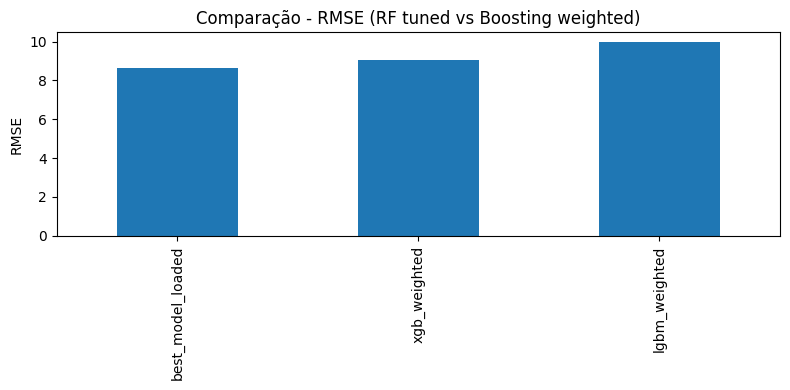

In [14]:
plt.figure(figsize=(8,4))
comparison_extra["rmse"].plot(kind="bar")
plt.title("Comparação - RMSE (RF tuned vs Boosting weighted)")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

In [15]:
bins_rf   = evaluate_by_bins(y_test, y_pred_best , q_low, q_high, label="best_model_loaded")
bins_xgbw = evaluate_by_bins(y_test, y_pred_xgb_w, q_low, q_high, label="xgb_weighted")
bins_lgbw = evaluate_by_bins(y_test, y_pred_lgbm_w, q_low, q_high, label="lgbm_weighted")

bins_all = pd.concat([bins_rf, bins_xgbw, bins_lgbw], ignore_index=True)
bins_all


,bin,n,mae,rmse,y_mean,model
0,high,6,17.517514,18.215888,36.465088,best_model_loaded
1,low,12,12.946464,13.333458,5.451890,best_model_loaded
2,mid,68,4.705815,5.766482,20.208598,best_model_loaded
3,high,6,18.288086,19.051020,36.465088,xgb_weighted
4,low,12,12.431482,13.096608,5.451890,xgb_weighted
5,mid,68,5.153987,6.433805,20.208598,xgb_weighted
6,high,6,18.524990,19.539794,36.465088,lgbm_weighted
7,low,12,14.086829,14.981931,5.451890,lgbm_weighted
8,mid,68,6.025592,7.248197,20.208598,lgbm_weighted


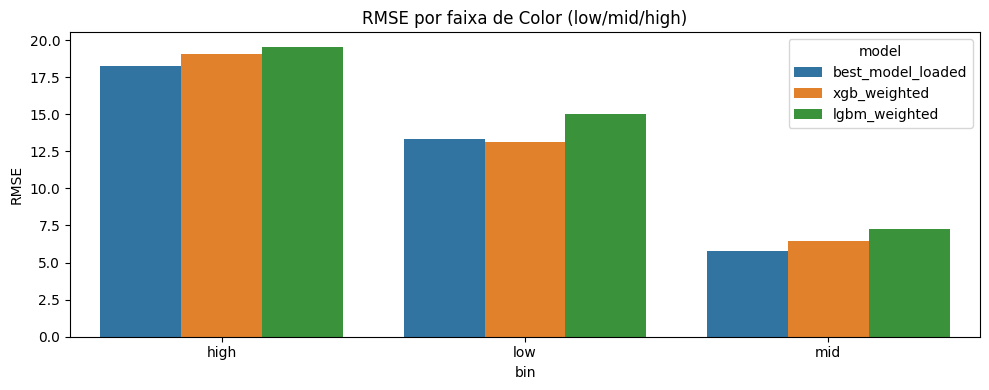

In [16]:
plt.figure(figsize=(10,4))
sns.barplot(data=bins_all, x="bin", y="rmse", hue="model")
plt.title("RMSE por faixa de Color (low/mid/high)")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


## 9. Análise de Erros e Decisão Final

A análise detalhada dos erros do modelo selecionado evidenciou que, apesar do bom desempenho global observado na etapa de modelagem avançada, o comportamento do erro não é homogêneo ao longo de toda a distribuição da variável alvo. Em particular, foi possível identificar maior variabilidade e aumento do erro absoluto nas faixas extremas de cor (EBC), que correspondem a regiões menos frequentes do conjunto de dados.

A avaliação por faixas permitiu compreender melhor os limites do modelo e reforçou a importância de analisar métricas de forma segmentada, especialmente em contextos industriais, nos quais desvios extremos podem representar maior risco operacional, mesmo que ocorram com menor frequência.

Foram exploradas abordagens complementares com o objetivo de mitigar essas limitações, incluindo o uso de ponderação de amostras em modelos de boosting e técnicas de reamostragem voltadas para dados desbalanceados em regressão. Essas estratégias demonstraram potencial para reduzir o erro nos extremos do target; entretanto, os ganhos observados foram acompanhados por perda de desempenho na faixa central, evidenciando um trade-off claro entre sensibilidade a regiões raras e estabilidade global do modelo.

Diante desses resultados, optou-se por manter o Random Forest otimizado como modelo principal para uso em produção, uma vez que ele apresenta o melhor equilíbrio entre precisão média, estabilidade temporal e robustez operacional. As abordagens ponderadas e os modelos especializados para extremos foram considerados como alternativas complementares, podendo ser utilizados de forma direcionada para análise de lotes específicos ou como ferramentas de apoio à tomada de decisão em situações de maior criticidade.

Essa etapa final reforça que a escolha do modelo não deve ser baseada exclusivamente em métricas agregadas, mas sim em uma compreensão aprofundada do comportamento dos erros e dos trade-offs envolvidos. A partir dessa análise, recomenda-se que futuras evoluções da solução considerem a ampliação da base de dados em regiões extremas, o refinamento contínuo das features e a implementação de mecanismos de monitoramento em produção, garantindo que o modelo permaneça alinhado às condições reais do processo produtivo ao longo do tempo.